# Mounting Drive

Mount drive to colab runtime so that you can save your model to drive. Colab resets after an hour or half of inactivity. Just in case your runtime disconnects, the progress is saved to drive and you can continue training from that checkpoint.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Getting Data

I have already downloaded data and done all the preprocessing and saved it to the drive. I've written code for fresh data download and pre-processing, use that.

## Getting data from drive

**DO NOT run this unless you have already preprocessed data on your drive.**

In [0]:
!unzip -q /content/drive/My\ Drive/resizeddata.zip

## Downloading data

Store data in new directory 'data'. Creating and changing the current working directory to 'data'.

In [0]:
!mkdir data
%cd data

/content/data


Downloading the train, validation, and test datasets.

In [0]:
!wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip

--2019-10-30 13:47:56--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/train.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.96
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5736557430 (5.3G) [application/zip]
Saving to: ‘train.zip’

train.zip           100%[===================>]   5.34G  21.4MB/s    in 4m 20s  

2019-10-30 13:52:17 (21.1 MB/s) - ‘train.zip’ saved [5736557430/5736557430]



In [0]:
!wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip

--2019-10-30 13:52:21--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/valid.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.116.56
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.116.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 864538487 (824M) [application/zip]
Saving to: ‘valid.zip’

valid.zip           100%[===================>] 824.49M  21.1MB/s    in 41s     

2019-10-30 13:53:02 (20.2 MB/s) - ‘valid.zip’ saved [864538487/864538487]



In [0]:
!wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip

--2019-10-30 13:53:05--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/skin-cancer/test.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.20.9
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.20.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5528640507 (5.1G) [application/zip]
Saving to: ‘test.zip’

test.zip            100%[===================>]   5.15G  21.4MB/s    in 4m 17s  

2019-10-30 13:57:22 (20.5 MB/s) - ‘test.zip’ saved [5528640507/5528640507]



Unzip and remove the zip files that were downloaded earlier.
Change the working directory back to '/content/'

In [0]:
!unzip -q test.zip
!unzip -q train.zip
!unzip -q valid.zip
!rm test.zip
!rm train.zip
!rm valid.zip
%cd /content/

/content


## Downloading ground_truth.csv

Download the ground truth csv file for testing out the ROC AUC and the confusion matrix

In [0]:
!wget https://raw.githubusercontent.com/udacity/dermatologist-ai/master/ground_truth.csv

--2019-10-31 06:57:21--  https://raw.githubusercontent.com/udacity/dermatologist-ai/master/ground_truth.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23918 (23K) [text/plain]
Saving to: ‘ground_truth.csv’

ground_truth.csv    100%[===================>]  23.36K  --.-KB/s    in 0.01s   

2019-10-31 06:57:21 (1.88 MB/s) - ‘ground_truth.csv’ saved [23918/23918]



# Importing dependencies

In [0]:
# inbuilt libraries
import os
import sys
import random
import itertools

# for mathematical operations and multidimensional arrays [Data analysis]
import numpy as np

# for dealing with dataframes [Data analysis]
import pandas as pd

# for making plots and visualizations [Data visualization]
import matplotlib.pyplot as plt

# for making plots easier [Data visualization]
import seaborn as sns

# Scikit Learn, Import the required evaluation techniques [Model evaluation]
from sklearn.metrics import roc_curve, auc, confusion_matrix

# Pillow, Deal with image data [Image manipulation]
from PIL import Image, ImageDraw

# Show the plots inline
%matplotlib inline

# Pytorch, deep learning framework [Deep learning framework]
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import WeightedRandomSampler

# Pytorch's torchvision, Deals with Computer vision [Utilities for CV]
import torchvision
from torchvision import transforms, models, datasets
from torchvision.datasets import ImageFolder

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Used to get progress of any loop [Track progress of training]
from tqdm.autonotebook import tqdm

## Global variables

In [0]:
train_path = '/content/data/train'
test_path = '/content/data/test'
valid_path = '/content/data/valid'
paths = {'train': train_path, 'valid': valid_path, 'test': test_path}
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Exploring data

In [0]:
print(f'Classes: {os.listdir("data/train")}')

Classes: ['seborrheic_keratosis', 'nevus', 'melanoma']


Check the sample photos from each folder

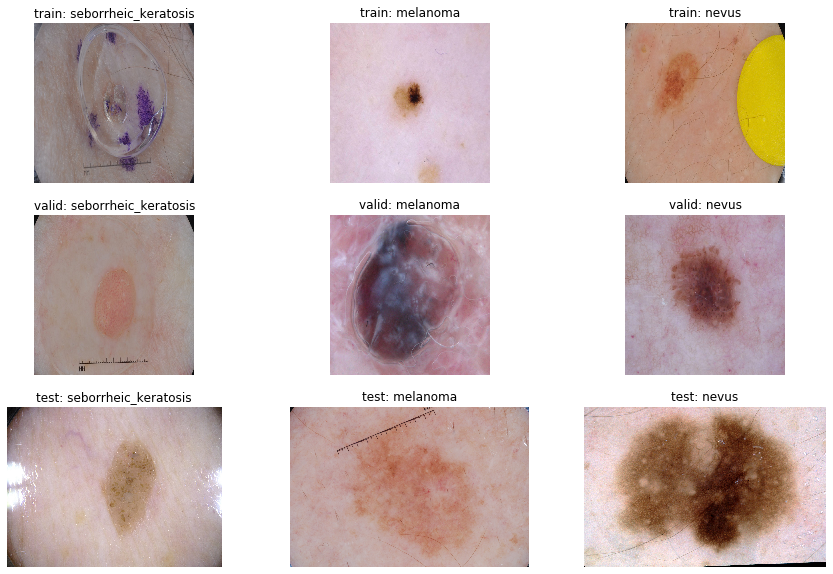

In [0]:
fig, ax = plt.subplots(3, 3, figsize=(15,10))
for i, (phase, p) in enumerate(paths.items()):
  for j, folder in enumerate(os.listdir(p)):
    for f in os.listdir(os.path.join(p, folder)):
      ax[i][j].imshow(plt.imread(os.path.join(p, folder, f)))
      print()
      ax[i][j].set_title(phase+': '+folder)
      ax[i][j].axis('off')
      break

Checking the size of each photo

In [0]:
for i, (phase, p) in enumerate(paths.items()):
  for j, folder in enumerate(os.listdir(p)):
    for f in os.listdir(os.path.join(p, folder)):
      im = plt.imread(os.path.join(p, folder, f))
      print(f'Shape of {phase}: {folder} is {im.shape}')
      break

Shape of train: seborrheic_keratosis is (2848, 4288, 3)
Shape of train: nevus is (2848, 4288, 3)
Shape of train: melanoma is (2848, 4288, 3)
Shape of valid: seborrheic_keratosis is (2000, 3008, 3)
Shape of valid: nevus is (2848, 4288, 3)
Shape of valid: melanoma is (2848, 4288, 3)
Shape of test: seborrheic_keratosis is (2848, 4288, 3)
Shape of test: nevus is (2000, 3008, 3)
Shape of test: melanoma is (2592, 3872, 3)


# Extra data

**Noted that the melanoma class has very few images. Downloaded the extra images from ISIC archive and stored on Google drive.** Doing this because we need to detect melanoma accurately because it is the deadliest form of cancer.

In [0]:
!unzip -q drive/My\ Drive/extradata.zip

In [0]:
!mv extradata/melanoma/* data/train/melanoma
!mv extradata/nevus/* data/train/nevus
!rm -r extradata

# Adding more data for validation from training set

Validation set is not of appropriate size to get any sort of insights on the model that we are training. So increasing the size of validation set by moving random files from training set to validation set.

In [0]:
valid_size = 0.2
def train2Val(classname):
    req = int((valid_size*(len(os.listdir('/content/data/valid/'+classname))+len(os.listdir('/content/data/train/'+classname))))-len(os.listdir('/content/data/valid/'+classname)))
    files = random.sample(os.listdir('/content/data/train/'+classname), k=req)
    print(req, files)
    for f in files:
        os.rename('/content/data/train/'+classname+'/'+f, '/content/data/valid/'+classname+'/'+f)
train2Val('melanoma')
train2Val('nevus')
train2Val('seborrheic_keratosis')

347 ['ISIC_0000432.jpg', 'ISIC_0034317.jpg', 'ISIC_0011494.jpg', 'ISIC_0029370.jpg', 'ISIC_0030183.jpg', 'ISIC_0013783.jpg', 'ISIC_0011958.jpg', 'ISIC_0030440.jpg', 'ISIC_0027238.jpg', 'ISIC_0000153.jpg', 'ISIC_0030333.jpg', 'ISIC_0028173.jpg', 'ISIC_0010707.jpg', 'ISIC_0027130.jpg', 'ISIC_0032265.jpg', 'ISIC_0010516.jpg', 'ISIC_0028220.jpg', 'ISIC_0011077.jpg', 'ISIC_0010655.jpg', 'ISIC_0033947.jpg', 'ISIC_0026870.jpg', 'ISIC_0010251.jpg', 'ISIC_0010537.jpg', 'ISIC_0000554.jpg', 'ISIC_0032313.jpg', 'ISIC_0033687.jpg', 'ISIC_0024967.jpg', 'ISIC_0028508.jpg', 'ISIC_0031005.jpg', 'ISIC_0025085.jpg', 'ISIC_0009908.jpg', 'ISIC_0032903.jpg', 'ISIC_0000548.jpg', 'ISIC_0014347.jpg', 'ISIC_0031915.jpg', 'ISIC_0032533.jpg', 'ISIC_0014325.jpg', 'ISIC_0032716.jpg', 'ISIC_0000429.jpg', 'ISIC_0033485.jpg', 'ISIC_0029651.jpg', 'ISIC_0011929.jpg', 'ISIC_0025520.jpg', 'ISIC_0013359.jpg', 'ISIC_0014337.jpg', 'ISIC_0027261.jpg', 'ISIC_0010023.jpg', 'ISIC_0010789.jpg', 'ISIC_0000549.jpg', 'ISIC_0028899.j

# Reduce image size for training

Most of the images are above 3-4 mb in size. The dataloaders will take time to fetch the image data because of the resizing done during runtime. Reducing the time wasted in training by reducing the size beforehand.

In [0]:
def resize(path, dirs):
    for item in dirs:
        if os.path.isfile(path+'/'+item):
            im = Image.open(path+'/'+item)
            f, e = os.path.splitext(path+'/'+item)
            imResize = im.resize((720,720), Image.ANTIALIAS)
            imResize.save(f + '.jpg', 'JPEG', quality=90)

In [0]:
path = "/content/data/train/melanoma"
dirs = os.listdir(path)
resize(path, dirs)
print(f'{path} Done...')
path = "/content/data/train/nevus"
dirs = os.listdir(path)
resize(path, dirs)
print(f'{path} Done...')
path = "/content/data/train/seborrheic_keratosis"
dirs = os.listdir(path)
resize(path, dirs)
print(f'{path} Done...')
path = "/content/data/valid/melanoma"
dirs = os.listdir(path)
resize(path, dirs)
print(f'{path} Done...')
path = "/content/data/valid/nevus"
dirs = os.listdir(path)
resize(path, dirs)
print(f'{path} Done...')
path = "/content/data/valid/seborrheic_keratosis"
dirs = os.listdir(path)
resize(path, dirs)
print(f'{path} Done...')

/content/data/train/melanoma Done...
/content/data/train/nevus Done...
/content/data/train/seborrheic_keratosis Done...
/content/data/valid/melanoma Done...
/content/data/valid/nevus Done...
/content/data/valid/seborrheic_keratosis Done...


# Dataset and DataLoader

Making a custom dataset that stores the samples, targets, and paths as well.

In [0]:
class MyDataset(ImageFolder):
    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target, path[9:]

DrawHair and DrawShape could be use to augment the existing dataset to simulate the hair and patches onto the photos so that the model doesn't overfit during training.

In [0]:
# draw random lines for fake hairs
class DrawHair:

  def __call__(self, img):

    draw = ImageDraw.Draw(img)

    for i in range(np.random.randint(5,20)):
        draw.line((np.random.randint(0,img.size[0]),
                   np.random.randint(0,img.size[1]),
                   np.random.randint(0,img.size[0]),
                   np.random.randint(0,img.size[1])), fill=0, width=np.random.randint(1,7))
    del draw

    return img

In [0]:
# draw random colored rectangles or ellipse for fake "patches"
class DrawShape:

  def __call__(self, img):

    draw = ImageDraw.Draw(img)

    corner = np.random.randint(1,5)
    coord = ((np.random.randint(0,img.size[0]/8) + img.size[0]/2* (corner==2 or corner==4), np.random.randint(0,img.size[1]/8 + img.size[0]/2* (corner==3 or corner==4))), 
                    (np.random.randint(0,img.size[0]/2) + img.size[0]/2* (corner==2 or corner==4), np.random.randint(0,img.size[1]/2 + img.size[0]/2* (corner==3 or corner==4))))
    if np.random.rand()<0.5:
        draw.ellipse(coord, fill=np.random.randint(0,240))
    else:
        draw.rectangle(coord, fill=np.random.randint(0,240))

    del draw

    return img

Setting up transforms for training, validation, and test datasets. Also creating the datasets itself.

In [0]:
train_transforms = transforms.Compose([
                                       transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(size=224, scale=(0.7,1)),
#                                        transforms.RandomApply([DrawHair()], p=0.25),
#                                        transforms.RandomApply([DrawShape()], p=0.25),
                                       transforms.RandomAffine(degrees=30, translate=(0.2,0.2), scale=(0.8,1.2), shear=(-8,8)),
                                      #  transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomVerticalFlip(),
                                       transforms.Resize((224, 224)),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])
])
test_transforms = transforms.Compose([
                                      transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])
])

trainset = MyDataset(train_path, transform=train_transforms)
validset = MyDataset(valid_path, transform=test_transforms)
testset = MyDataset(test_path, transform=test_transforms)

### Oversampling class seborrheic_keratosis

**Noted that the keratosis(class 2) is having very less amount of data.** Oversampling the class 2 to remove the imbalance in the dataset.

In [0]:
target = trainset.targets
class_sample_count = np.unique(target, return_counts=True)[1]

weight = 1. / class_sample_count
samples_weight = weight[target]
samples_weight = torch.from_numpy(samples_weight)
weight_sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

In [0]:
trainloader = DataLoader(trainset, batch_size=32, sampler=weight_sampler, num_workers=4)
validloader = DataLoader(validset, batch_size=32, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=32, num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Length of training dataset: 3387
Length of validation dataset: 846
Length of test dataset: 600
Size of images batch: torch.Size([32, 3, 224, 224])
Label: 2	Path: data/train/seborrheic_keratosis/ISIC_0014311.jpg


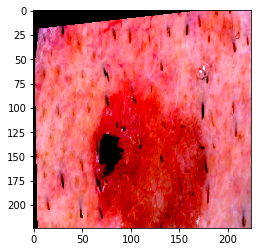

In [0]:
images, labels, paths = next(iter(trainloader))
ind = 0
print(f'Length of training dataset: {len(trainloader.dataset)}')
print(f'Length of validation dataset: {len(validloader.dataset)}')
print(f'Length of test dataset: {len(testset)}')
print(f'Size of images batch: {images.shape}')

image = np.transpose(images[0].numpy(), (1, 2, 0))
plt.imshow(image)
print(f'Label: {labels[ind]}\tPath: {paths[ind]}')

# Model

Imagenet pretrained models ported to Pytorch. Read more about DenseNet161 at https://www.kaggle.com/pytorch/densenet161

We are going to use transfer learning for training our model.

In [0]:
model = models.densenet161(pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:01<00:00, 99.2MB/s]


Freezing all layers of model

In [0]:
for param in model.parameters():
  param.requires_grad = False

Unfreeze last two denseblocks for training. (Allow back-propagation for last two dense blocks)

In [0]:
for param in (model.features.denseblock3).parameters():
  param.requires_grad = True
for param in (model.features.denseblock4).parameters():
  param.requires_grad = True

Extending the last layer for our use case. Getting the log softmax output(probabilities) for each class.

In [0]:
model.classifier = nn.Sequential(nn.Linear(2208, 1000),
                                nn.ReLU(),
                                nn.Dropout(),
                                nn.Linear(1000, 3),
                                nn.LogSoftmax(dim=1))

Setting weights for melanoma class to be 50% more than other classes because it is the deadliest cancer and we will penalize our model for the melanoma class more than other classes as we want to predict melanoma accuractely with few false negatives.

Selecting Negative Log Likelihood Loss for calculating loss and Adam optimizer for better training and convergence.

In [0]:
weights = [1.5, 1, 1]
model.to(device)

criterion = nn.NLLLoss(torch.Tensor(weights).to(device))
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001, weight_decay=1e-3)

# Training

Training function that saves best model with maximum accuracy on validation dataset and saves the model every 10 epochs.

In [0]:
def train(model, dataloaders, criterion, optimizer, epochs=30, max_acc=-np.Inf, saveto='model.pt', continue_train=False):
    best_weights = model.state_dict()
    
    if(continue_train):
        model = torch.load(saveto).to(device)

    for epoch in range(epochs):
        print(f'\nEpoch{epoch+1}/{epochs}')
        print('--------------------')
        for phase in ['train', 'eval']:
            if(phase=='train'):
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0

            for data, target, _ in tqdm(dataloaders[phase]):
                torch.cuda.empty_cache()
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                if(type(output)==tuple):
                    output, _ = output
                loss = criterion(output, target)
                
                _, preds = torch.max(output.data, 1)
                running_corrects += torch.sum(preds == target.data).item()
                

                if(phase=='train'):
                    loss.backward()
                    optimizer.step()
                
                running_loss += loss.item() * data.size(0)
                del data
                del target
                del _
            
            epoch_loss = running_loss/len(dataloaders[phase].dataset)
            acc = running_corrects/len(dataloaders[phase].dataset)

            print(f'\nLoss: {epoch_loss}\tAcc: {acc} in {phase}')

            if(phase=='eval' and acc>max_acc):
                print('\nSaving new model...')
                max_acc = acc
                best_weights = model.state_dict()
                torch.save(model, '/content/drive/My Drive/skinpredata.pt')
        if((epoch+1)%10==0):
            n = 'drive/My Drive/skinpredata'+str(epoch+1)+'.pt'
            torch.save(model, n)
        for param in optimizer.param_groups:
            print('Learning rate:', param['lr'])
        
    print(f'\nTraining Complete!\nMaximum accuracy: {max_acc}')

    model.load_state_dict(best_weights)
    return model

In [0]:
model = train(model, {'train': trainloader, 'eval': validloader}, criterion, optimizer, epochs=100)


Epoch1/100
--------------------




Loss: 0.7906172082316464	Acc: 0.6462946560377916 in train




Loss: 0.7413455874925527	Acc: 0.682033096926714 in eval

Saving new model...
Learning rate: 0.0001

Epoch2/100
--------------------




Loss: 0.5262741299727197	Acc: 0.781812813699439 in train




Loss: 0.5834444124366093	Acc: 0.735224586288416 in eval

Saving new model...
Learning rate: 0.0001

Epoch3/100
--------------------




Loss: 0.4469193652522997	Acc: 0.8080897549453794 in train




Loss: 0.6031346648015593	Acc: 0.7458628841607565 in eval

Saving new model...
Learning rate: 0.0001

Epoch4/100
--------------------




Loss: 0.37794167888280666	Acc: 0.8444050782403307 in train




Loss: 0.6086671453136643	Acc: 0.7021276595744681 in eval
Learning rate: 0.0001

Epoch5/100
--------------------




Loss: 0.33541239730756406	Acc: 0.8671390611160319 in train




Loss: 0.5420857308604193	Acc: 0.7801418439716312 in eval

Saving new model...
Learning rate: 0.0001

Epoch6/100
--------------------




Loss: 0.33886935556395975	Acc: 0.8618246235606731 in train




Loss: 0.5480589682046967	Acc: 0.7789598108747045 in eval
Learning rate: 0.0001

Epoch7/100
--------------------




Loss: 0.293932346756352	Acc: 0.8801299084735754 in train




Loss: 0.504253193700849	Acc: 0.7907801418439716 in eval

Saving new model...
Learning rate: 0.0001

Epoch8/100
--------------------




Loss: 0.2612725353439825	Acc: 0.8957779746087984 in train




Loss: 0.5949731270472208	Acc: 0.7825059101654847 in eval
Learning rate: 0.0001

Epoch9/100
--------------------




Loss: 0.25376123960721375	Acc: 0.8993209329790375 in train




Loss: 0.5442601524064445	Acc: 0.8085106382978723 in eval

Saving new model...
Learning rate: 0.0001

Epoch10/100
--------------------




Loss: 0.22265967966041136	Acc: 0.9114260407440212 in train




Loss: 0.6187642745092405	Acc: 0.8049645390070922 in eval
Learning rate: 0.0001

Epoch11/100
--------------------




Loss: 0.20955381000203863	Acc: 0.9137880129908473 in train




Loss: 0.6035216197054437	Acc: 0.8073286052009456 in eval
Learning rate: 0.0001

Epoch12/100
--------------------




Loss: 0.1959775359028027	Acc: 0.9253026276941246 in train




Loss: 0.5544738246405378	Acc: 0.8120567375886525 in eval

Saving new model...
Learning rate: 0.0001

Epoch13/100
--------------------




Loss: 0.19491642578041657	Acc: 0.9226454089164452 in train




Loss: 0.6691223828927845	Acc: 0.8132387706855791 in eval

Saving new model...
Learning rate: 0.0001

Epoch14/100
--------------------




Loss: 0.15920960545927013	Acc: 0.933569530558016 in train




Loss: 0.6660435492828947	Acc: 0.806146572104019 in eval
Learning rate: 0.0001

Epoch15/100
--------------------




Loss: 0.16049243504050067	Acc: 0.9379982285208148 in train




Loss: 0.6549906688379058	Acc: 0.8085106382978723 in eval
Learning rate: 0.0001

Epoch16/100
--------------------




Loss: 0.1755093049344884	Acc: 0.9288455860643637 in train




Loss: 0.6835588388690994	Acc: 0.789598108747045 in eval
Learning rate: 0.0001

Epoch17/100
--------------------




Loss: 0.14631948113256688	Acc: 0.9456746383229997 in train




Loss: 0.670795110523278	Acc: 0.8096926713947991 in eval
Learning rate: 0.0001

Epoch18/100
--------------------




Loss: 0.15047399817594992	Acc: 0.9439031591378801 in train




Loss: 0.6144096551212013	Acc: 0.8250591016548463 in eval

Saving new model...
Learning rate: 0.0001

Epoch19/100
--------------------




Loss: 0.14077974729633697	Acc: 0.9444936521995867 in train




Loss: 0.6305430096091954	Acc: 0.7919621749408984 in eval
Learning rate: 0.0001

Epoch20/100
--------------------




Loss: 0.12271088001309752	Acc: 0.9536462946560378 in train




Loss: 0.6374788663876254	Acc: 0.8108747044917257 in eval
Learning rate: 0.0001

Epoch21/100
--------------------




Loss: 0.12543767204072084	Acc: 0.9501033362857987 in train




Loss: 0.6718131641969614	Acc: 0.8108747044917257 in eval
Learning rate: 0.0001

Epoch22/100
--------------------




Loss: 0.11785253672991174	Acc: 0.953941541186891 in train




Loss: 0.6335044790666999	Acc: 0.8096926713947991 in eval
Learning rate: 0.0001

Epoch23/100
--------------------




Loss: 0.11157114708321546	Acc: 0.9598464718039563 in train




Loss: 0.7522515511540938	Acc: 0.7966903073286052 in eval
Learning rate: 0.0001

Epoch24/100
--------------------




Loss: 0.1099685783681394	Acc: 0.9622084440507824 in train




Loss: 0.6826883903913746	Acc: 0.8120567375886525 in eval
Learning rate: 0.0001

Epoch25/100
--------------------




Loss: 0.12649710701213743	Acc: 0.9563035134337171 in train




Loss: 0.691016599852988	Acc: 0.7990543735224587 in eval
Learning rate: 0.0001

Epoch26/100
--------------------




Loss: 0.10213518635446003	Acc: 0.9645704162976085 in train




Loss: 0.6959547184178734	Acc: 0.8238770685579196 in eval
Learning rate: 0.0001

Epoch27/100
--------------------




Loss: 0.10192893676466389	Acc: 0.9627989371124889 in train




Loss: 0.8312992625484512	Acc: 0.8144208037825059 in eval
Learning rate: 0.0001

Epoch28/100
--------------------




Loss: 0.09081821374381789	Acc: 0.965160909359315 in train




Loss: 0.855865601388557	Acc: 0.7825059101654847 in eval
Learning rate: 0.0001

Epoch29/100
--------------------




Loss: 0.0951189745469434	Acc: 0.9704753469146737 in train




Loss: 0.6058596235922324	Acc: 0.817966903073286 in eval
Learning rate: 0.0001

Epoch30/100
--------------------




Loss: 0.09564118390858332	Acc: 0.963979923235902 in train




Loss: 0.7822339786458804	Acc: 0.8108747044917257 in eval
Learning rate: 0.0001

Epoch31/100
--------------------




Loss: 0.09961366143318486	Acc: 0.9666371420135813 in train




Loss: 0.6814890426383232	Acc: 0.8250591016548463 in eval
Learning rate: 0.0001

Epoch32/100
--------------------




Loss: 0.07537632124294459	Acc: 0.9728373191614998 in train




Loss: 0.711248356963444	Acc: 0.8297872340425532 in eval

Saving new model...
Learning rate: 0.0001

Epoch33/100
--------------------




Loss: 0.0682689409932891	Acc: 0.9743135518157662 in train




Loss: 0.8396740846036456	Acc: 0.8167848699763594 in eval
Learning rate: 0.0001

Epoch34/100
--------------------




Loss: 0.0804414829832634	Acc: 0.9713610865072335 in train




Loss: 1.011317235780946	Acc: 0.793144208037825 in eval
Learning rate: 0.0001

Epoch35/100
--------------------




Loss: 0.08963148688343701	Acc: 0.9654561558901683 in train




Loss: 0.7916094022439727	Acc: 0.8191489361702128 in eval
Learning rate: 0.0001

Epoch36/100
--------------------




Loss: 0.07571056186613921	Acc: 0.9719515795689401 in train




Loss: 0.7945082830199113	Acc: 0.8274231678486997 in eval
Learning rate: 0.0001

Epoch37/100
--------------------




Loss: 0.07698904270988705	Acc: 0.9737230587540596 in train




Loss: 0.9118282346860737	Acc: 0.7966903073286052 in eval
Learning rate: 0.0001

Epoch38/100
--------------------




Loss: 0.08193887219796464	Acc: 0.9704753469146737 in train




Loss: 0.9434727445843654	Acc: 0.83451536643026 in eval

Saving new model...
Learning rate: 0.0001

Epoch39/100
--------------------




Loss: 0.08288701837384704	Acc: 0.9713610865072335 in train




Loss: 0.8806099677480422	Acc: 0.8451536643026005 in eval

Saving new model...
Learning rate: 0.0001

Epoch40/100
--------------------




Loss: 0.07180184726874174	Acc: 0.9746087983466194 in train




Loss: 0.8966419417807396	Acc: 0.8416075650118203 in eval
Learning rate: 0.0001

Epoch41/100
--------------------




Loss: 0.0883371445303879	Acc: 0.9681133746678476 in train




Loss: 0.7975705050407572	Acc: 0.8392434988179669 in eval
Learning rate: 0.0001

Epoch42/100
--------------------




Loss: 0.05644237169468512	Acc: 0.9781517567168586 in train




Loss: 0.9428430379987045	Acc: 0.8297872340425532 in eval
Learning rate: 0.0001

Epoch43/100
--------------------




Loss: 0.07574629138221352	Acc: 0.9692943607912607 in train




Loss: 0.8815445818940517	Acc: 0.8262411347517731 in eval
Learning rate: 0.0001

Epoch44/100
--------------------




Loss: 0.06931318409778321	Acc: 0.9731325656923531 in train




Loss: 0.9693257943958256	Acc: 0.7955082742316785 in eval
Learning rate: 0.0001

Epoch45/100
--------------------




Loss: 0.07197027159610046	Acc: 0.9743135518157662 in train




Loss: 0.867453538216034	Acc: 0.8262411347517731 in eval
Learning rate: 0.0001

Epoch46/100
--------------------




Loss: 0.06730233469182212	Acc: 0.974018305284913 in train




Loss: 0.8212026526741948	Acc: 0.8286052009456265 in eval
Learning rate: 0.0001

Epoch47/100
--------------------




Loss: 0.05804854667170019	Acc: 0.9784470032477118 in train




Loss: 0.8483600959569286	Acc: 0.8297872340425532 in eval
Learning rate: 0.0001

Epoch48/100
--------------------




Loss: 0.08482837388833646	Acc: 0.9698848538529672 in train




Loss: 0.7227841261289926	Acc: 0.806146572104019 in eval
Learning rate: 0.0001

Epoch49/100
--------------------




Loss: 0.06517152063898327	Acc: 0.9757897844700325 in train




Loss: 0.736842081901875	Acc: 0.8356973995271868 in eval
Learning rate: 0.0001

Epoch50/100
--------------------




Loss: 0.07843224975385778	Acc: 0.9722468260997933 in train




Loss: 0.9786764956816996	Acc: 0.7943262411347518 in eval
Learning rate: 0.0001

Epoch51/100
--------------------




Loss: 0.08180619553413439	Acc: 0.9725420726306466 in train




Loss: 0.6855311795329371	Acc: 0.8215130023640662 in eval
Learning rate: 0.0001

Epoch52/100
--------------------




Loss: 0.04946836065429482	Acc: 0.9837614408030706 in train




Loss: 0.8655662601439383	Acc: 0.8215130023640662 in eval
Learning rate: 0.0001

Epoch53/100
--------------------




Loss: 0.05777802599876116	Acc: 0.9772660171242988 in train




Loss: 0.9013222307319055	Acc: 0.8404255319148937 in eval
Learning rate: 0.0001

Epoch54/100
--------------------




Loss: 0.06032046904676883	Acc: 0.9760850310008857 in train




Loss: 0.7652997164579711	Acc: 0.8463356973995272 in eval

Saving new model...
Learning rate: 0.0001

Epoch55/100
--------------------




Loss: 0.06927790499812282	Acc: 0.9760850310008857 in train




Loss: 0.7529930846135949	Acc: 0.8380614657210402 in eval
Learning rate: 0.0001

Epoch56/100
--------------------




Loss: 0.050808485758504336	Acc: 0.9819899616179509 in train




Loss: 0.9803687959698075	Acc: 0.8226950354609929 in eval
Learning rate: 0.0001

Epoch57/100
--------------------




Loss: 0.03980980625987638	Acc: 0.9855329199881901 in train




Loss: 0.8701576014218882	Acc: 0.8463356973995272 in eval
Learning rate: 0.0001

Epoch58/100
--------------------




Loss: 0.06802054488460046	Acc: 0.9731325656923531 in train




Loss: 1.0046613657358268	Acc: 0.8380614657210402 in eval
Learning rate: 0.0001

Epoch59/100
--------------------




Loss: 0.08259867225859698	Acc: 0.9722468260997933 in train




Loss: 0.8773211705769207	Acc: 0.8356973995271868 in eval
Learning rate: 0.0001

Epoch60/100
--------------------




Loss: 0.07052292156296915	Acc: 0.9746087983466194 in train




Loss: 0.9520905598399205	Acc: 0.806146572104019 in eval
Learning rate: 0.0001

Epoch61/100
--------------------




Loss: 0.050385631021174895	Acc: 0.9825804546796575 in train




Loss: 1.0003050503719502	Acc: 0.817966903073286 in eval
Learning rate: 0.0001

Epoch62/100
--------------------




Loss: 0.07379222528171427	Acc: 0.9692943607912607 in train




Loss: 0.904358495493589	Acc: 0.8191489361702128 in eval
Learning rate: 0.0001

Epoch63/100
--------------------




Loss: 0.06442466886576066	Acc: 0.9784470032477118 in train




Loss: 0.9688388384332611	Acc: 0.8108747044917257 in eval
Learning rate: 0.0001

Epoch64/100
--------------------




Loss: 0.05747426877687525	Acc: 0.9813994685562445 in train




Loss: 0.8618946186757821	Acc: 0.8333333333333334 in eval
Learning rate: 0.0001

Epoch65/100
--------------------




Loss: 0.07638976275964864	Acc: 0.9737230587540596 in train




Loss: 0.8633501866466892	Acc: 0.8356973995271868 in eval
Learning rate: 0.0001

Epoch66/100
--------------------




Loss: 0.05594625122732985	Acc: 0.9825804546796575 in train




Loss: 1.127016206864206	Acc: 0.806146572104019 in eval
Learning rate: 0.0001

Epoch67/100
--------------------




Loss: 0.05237713652399787	Acc: 0.9811042220253912 in train




Loss: 0.9209787043837508	Acc: 0.8404255319148937 in eval
Learning rate: 0.0001

Epoch68/100
--------------------




Loss: 0.05538941938501563	Acc: 0.9837614408030706 in train




Loss: 0.9776456635753595	Acc: 0.8274231678486997 in eval
Learning rate: 0.0001

Epoch69/100
--------------------




Loss: 0.07032316832236477	Acc: 0.9737230587540596 in train




Loss: 0.7957868902959441	Acc: 0.8404255319148937 in eval
Learning rate: 0.0001

Epoch70/100
--------------------




Loss: 0.05910826600474314	Acc: 0.9775612636551521 in train




Loss: 1.0342337246059525	Acc: 0.8167848699763594 in eval
Learning rate: 0.0001

Epoch71/100
--------------------




Loss: 0.05576311448461931	Acc: 0.9805137289636847 in train




Loss: 0.8258949732385911	Acc: 0.8297872340425532 in eval
Learning rate: 0.0001

Epoch72/100
--------------------




Loss: 0.06518801013494456	Acc: 0.9775612636551521 in train




Loss: 0.9985187070589538	Acc: 0.8309692671394799 in eval
Learning rate: 0.0001

Epoch73/100
--------------------




Loss: 0.0693227727926337	Acc: 0.9746087983466194 in train




Loss: 0.794553180923135	Acc: 0.8427895981087471 in eval
Learning rate: 0.0001

Epoch74/100
--------------------




Loss: 0.07352291842125706	Acc: 0.9734278122232064 in train




Loss: 0.7889767966230992	Acc: 0.8262411347517731 in eval
Learning rate: 0.0001

Epoch75/100
--------------------




Loss: 0.062029777065575	Acc: 0.9772660171242988 in train




Loss: 0.9094846984173389	Acc: 0.8073286052009456 in eval
Learning rate: 0.0001

Epoch76/100
--------------------




Loss: 0.05377688500529762	Acc: 0.9825804546796575 in train




Loss: 0.9037114258230297	Acc: 0.8404255319148937 in eval
Learning rate: 0.0001

Epoch77/100
--------------------




Loss: 0.05634945974684427	Acc: 0.9799232359019782 in train




Loss: 0.9894912693799247	Acc: 0.8108747044917257 in eval
Learning rate: 0.0001

Epoch78/100
--------------------




Loss: 0.06229371866219544	Acc: 0.9778565101860053 in train




Loss: 0.97680065141502	Acc: 0.8297872340425532 in eval
Learning rate: 0.0001

Epoch79/100
--------------------




Loss: 0.05785477282174189	Acc: 0.9793327428402716 in train




Loss: 0.9432388200880365	Acc: 0.8380614657210402 in eval
Learning rate: 0.0001

Epoch80/100
--------------------




Loss: 0.06025679850555431	Acc: 0.9793327428402716 in train




Loss: 0.8971485692840377	Acc: 0.8250591016548463 in eval
Learning rate: 0.0001

Epoch81/100
--------------------




Loss: 0.0537200380663341	Acc: 0.9819899616179509 in train




Loss: 0.7258052896382398	Acc: 0.8309692671394799 in eval
Learning rate: 0.0001

Epoch82/100
--------------------




Loss: 0.05693038470123611	Acc: 0.9766755240625923 in train




Loss: 0.9753735392369841	Acc: 0.8191489361702128 in eval
Learning rate: 0.0001

Epoch83/100
--------------------




Loss: 0.06912263239570818	Acc: 0.9772660171242988 in train




Loss: 0.8222581828739626	Acc: 0.8238770685579196 in eval
Learning rate: 0.0001

Epoch84/100
--------------------




Loss: 0.06500325864634622	Acc: 0.9757897844700325 in train




Loss: 0.8321120445891756	Acc: 0.83451536643026 in eval
Learning rate: 0.0001

Epoch85/100
--------------------




Loss: 0.05723340453534377	Acc: 0.9799232359019782 in train




Loss: 0.88769355880418	Acc: 0.8321513002364066 in eval
Learning rate: 0.0001

Epoch86/100
--------------------




Loss: 0.04890379912002991	Acc: 0.9828757012105108 in train




Loss: 0.8765374816267203	Acc: 0.8416075650118203 in eval
Learning rate: 0.0001

Epoch87/100
--------------------




Loss: 0.04088796688183803	Acc: 0.9864186595807499 in train




Loss: 0.9024939289047926	Acc: 0.8297872340425532 in eval
Learning rate: 0.0001

Epoch88/100
--------------------




Loss: 0.05052624454549677	Acc: 0.983170947741364 in train




Loss: 1.095352180460666	Acc: 0.789598108747045 in eval
Learning rate: 0.0001

Epoch89/100
--------------------




Loss: 0.04061013555078863	Acc: 0.984351933864777 in train




Loss: 0.9503672716183583	Acc: 0.8427895981087471 in eval
Learning rate: 0.0001

Epoch90/100
--------------------




Loss: 0.05295160479056103	Acc: 0.9825804546796575 in train




Loss: 1.0514746367508638	Acc: 0.8144208037825059 in eval
Learning rate: 0.0001

Epoch91/100
--------------------




Loss: 0.081881329450775	Acc: 0.9728373191614998 in train




Loss: 0.9065083779623604	Acc: 0.8250591016548463 in eval
Learning rate: 0.0001

Epoch92/100
--------------------




Loss: 0.05544008801525977	Acc: 0.9816947150870977 in train




Loss: 1.0666131909152858	Acc: 0.8356973995271868 in eval
Learning rate: 0.0001

Epoch93/100
--------------------




Loss: 0.06183451810174718	Acc: 0.9781517567168586 in train




Loss: 0.8124635298483197	Acc: 0.8203309692671394 in eval
Learning rate: 0.0001

Epoch94/100
--------------------




Loss: 0.062416982742706725	Acc: 0.9769707705934455 in train




Loss: 0.8780699820383221	Acc: 0.8321513002364066 in eval
Learning rate: 0.0001

Epoch95/100
--------------------




Loss: 0.05016838323583665	Acc: 0.9819899616179509 in train




Loss: 1.2453825882422445	Acc: 0.8297872340425532 in eval
Learning rate: 0.0001

Epoch96/100
--------------------




Loss: 0.0661236125924153	Acc: 0.9766755240625923 in train




Loss: 0.8922421805402065	Acc: 0.8486997635933806 in eval

Saving new model...
Learning rate: 0.0001

Epoch97/100
--------------------




Loss: 0.04446933052307619	Acc: 0.9837614408030706 in train




Loss: 0.8944594369007904	Acc: 0.8380614657210402 in eval
Learning rate: 0.0001

Epoch98/100
--------------------




Loss: 0.06263836326145222	Acc: 0.9796279893711249 in train




Loss: 0.8536271022425758	Acc: 0.859338061465721 in eval

Saving new model...
Learning rate: 0.0001

Epoch99/100
--------------------




Loss: 0.06682927839530581	Acc: 0.9731325656923531 in train




Loss: 0.9538592807508248	Acc: 0.8321513002364066 in eval
Learning rate: 0.0001

Epoch100/100
--------------------




Loss: 0.06848600186937708	Acc: 0.9784470032477118 in train




Loss: 1.0041921172581665	Acc: 0.8238770685579196 in eval
Learning rate: 0.0001

Training Complete!
Maximum accuracy: 0.859338061465721


# Evaluation

In [0]:
def plot_roc_auc(y_true, y_pred):
    """
    This function plots the ROC curves and provides the scores.
    """

    # initialize dictionaries and array
    fpr = dict()
    tpr = dict()
    roc_auc = np.zeros(3)
    
    # prepare for figure
    plt.figure(figsize=(8,6))
    colors = ['aqua', 'cornflowerblue']

    # for both classification tasks (categories 1 and 2)
    for i in range(2):
        # obtain ROC curve
        fpr[i], tpr[i], _ = roc_curve(y_true[:,i], y_pred[:,i])
        # obtain ROC AUC
        roc_auc[i] = auc(fpr[i], tpr[i])
        # plot ROC curve
        plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
                 label='ROC curve for task {d} (area = {f:.2f})'.format(d=i+1, f=roc_auc[i]))
    # get score for category 3
    roc_auc[2] = np.average(roc_auc[:2])
    
    # format figure
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves')
    plt.legend(loc="lower right")
    plt.show()
    
    # print scores
    for i in range(3):
        print('Category {d} Score: {f:.3f}'. format(d=i+1, f=roc_auc[i]))

In [0]:
def plot_confusion_matrix(y_true, y_pred, thresh, classes):
    """
    This function plots the (normalized) confusion matrix.
    """

    # obtain class predictions from probabilities
    y_pred = (y_pred>=thresh)*1
    # obtain (unnormalized) confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # normalize confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [0]:
def getPredictions(model, predsFilename):
    model.cuda()
    running_corrects = 0
    with torch.no_grad():
        paths = []
        probs1 = []
        probs2 = []
        for data, target, path in tqdm(testloader):
            torch.cuda.empty_cache()
            data, target = data.cuda(), target.cuda()
            output = model(data)
            _, preds = torch.max(output.data, 1)
            running_corrects += torch.sum(preds == target.data).item()

            for p, out in zip(path, output):
                prob = torch.exp(out)
                prob = torch.div(prob, torch.sum(prob))
                paths.append(p)
                probs1.append(prob[0].item())
                probs2.append(prob[2].item())
    print('Correct labels:', running_corrects, '/', len(testloader.dataset))
    print('Correctness score:', running_corrects/len(testloader.dataset))
    df = pd.DataFrame(list(zip(paths, probs1, probs2)), columns=['Id', 'task_1', 'task_2'])
    df.sort_values('Id', inplace=True)
    df.to_csv(predsFilename, index=False)

In [0]:
def plotMetrics(predsFilename, threshold):
    preds_path = predsFilename

    # get ground truth labels for test dataset
    truth = pd.read_csv('ground_truth.csv')
    y_true = truth.as_matrix(columns=["task_1", "task_2"])

    # get model predictions for test dataset
    y_pred = pd.read_csv(preds_path)
    y_pred = y_pred.as_matrix(columns=["task_1", "task_2"])

    # plot ROC curves and print scores
    plot_roc_auc(y_true, y_pred)
    # plot confusion matrix
    classes = ['benign', 'malignant']
    plot_confusion_matrix(y_true[:,0], y_pred[:,0], threshold, classes)

In [0]:
def getAccuracy(model, dataloader):
    model.eval()
    test_loss = 0
    running_corrects = 0
    for data, target, path in tqdm(dataloader):
        data, target = data.cuda(), target.cuda()
        output = model(data)

        _, preds = torch.max(output.data, 1)

        loss = criterion(output, target)
        test_loss += loss.item() * data.size(0)
        running_corrects += torch.sum(preds == target.data).item()

    print(test_loss/len(dataloader.dataset))
    print('Correct labels:', running_corrects, '/', len(dataloader.dataset))
    print('Correctness score:', running_corrects/len(dataloader.dataset))

## Evaluating all models

Getting the predictions as csv file.

In [0]:
for i in range(10):
    getPredictions(torch.load(f'drive/My Drive/skinpredata{(i+1)*10}.pt'), f'preds{i}.csv')

### Plot ROC AUC and confusion matrix

Getting AUC, ROC and confusion matrices for evaluation. Setting a threshold for confusion matrices.

===================== Model 10 =====================


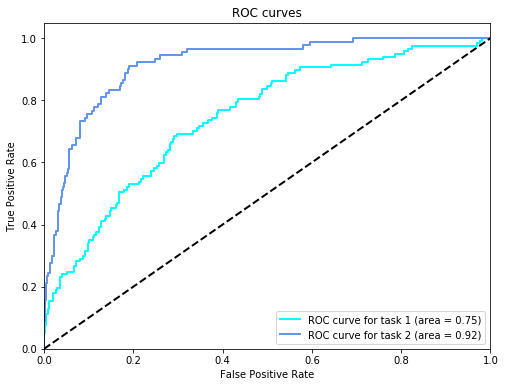

Category 1 Score: 0.746
Category 2 Score: 0.917
Category 3 Score: 0.831


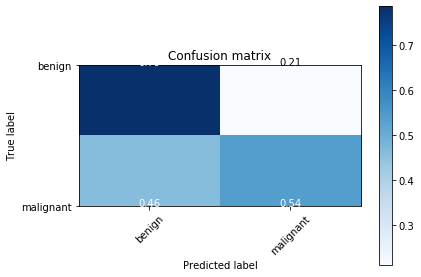

===================== Model 20 =====================


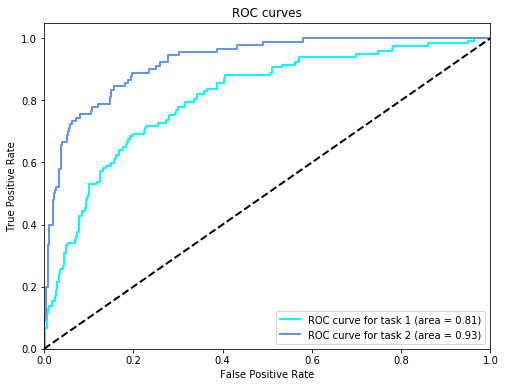

Category 1 Score: 0.809
Category 2 Score: 0.925
Category 3 Score: 0.867


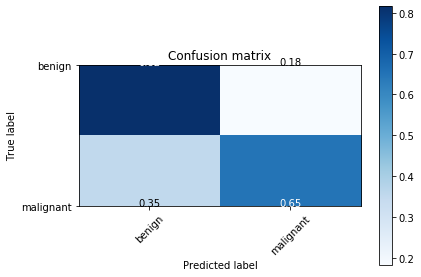

===================== Model 30 =====================


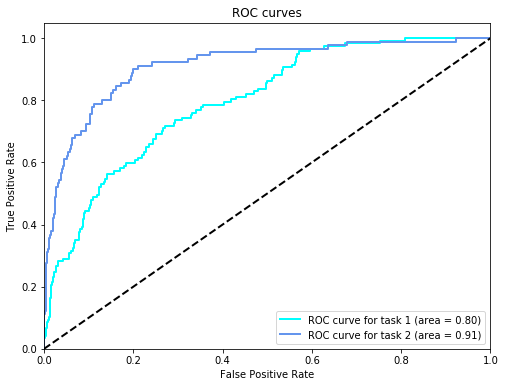

Category 1 Score: 0.797
Category 2 Score: 0.911
Category 3 Score: 0.854


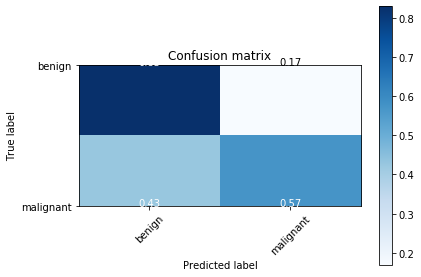

===================== Model 40 =====================


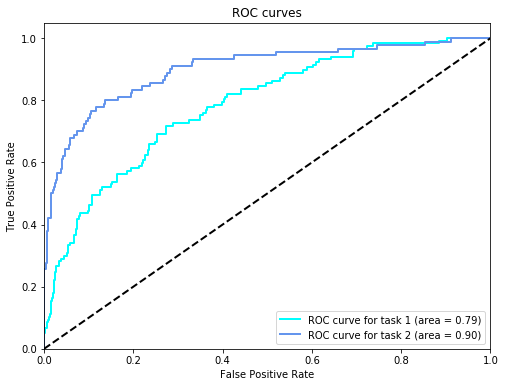

Category 1 Score: 0.785
Category 2 Score: 0.899
Category 3 Score: 0.842


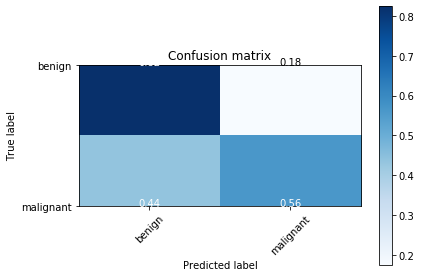

===================== Model 50 =====================


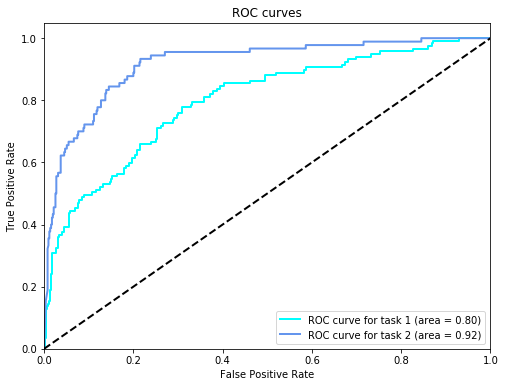

Category 1 Score: 0.798
Category 2 Score: 0.917
Category 3 Score: 0.858


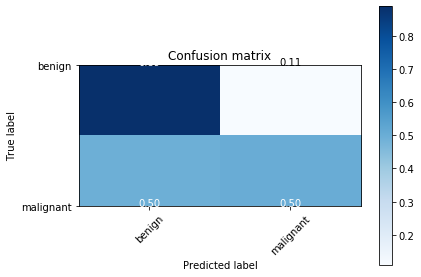

===================== Model 60 =====================


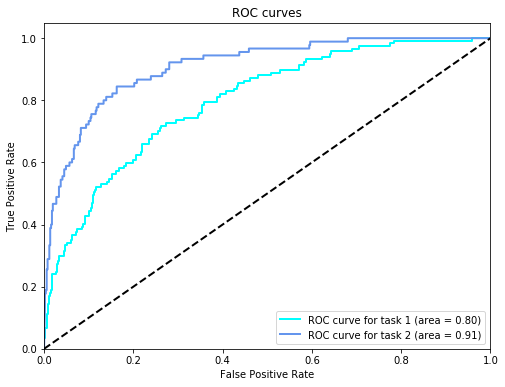

Category 1 Score: 0.797
Category 2 Score: 0.909
Category 3 Score: 0.853


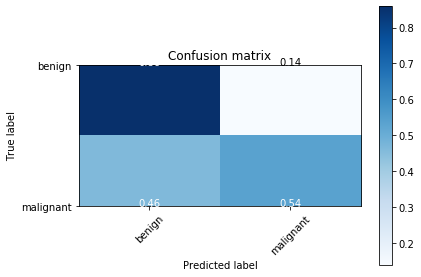

===================== Model 70 =====================


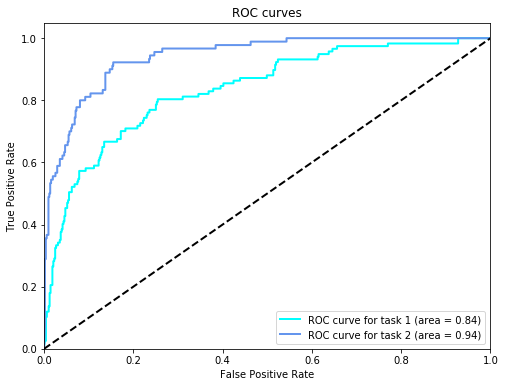

Category 1 Score: 0.836
Category 2 Score: 0.941
Category 3 Score: 0.888


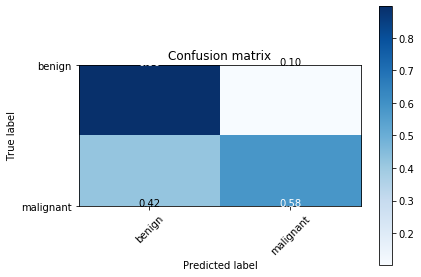

===================== Model 80 =====================


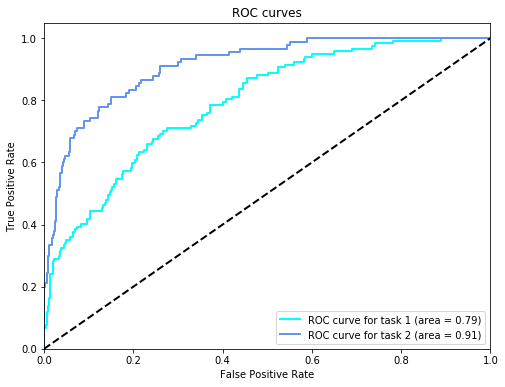

Category 1 Score: 0.792
Category 2 Score: 0.911
Category 3 Score: 0.851


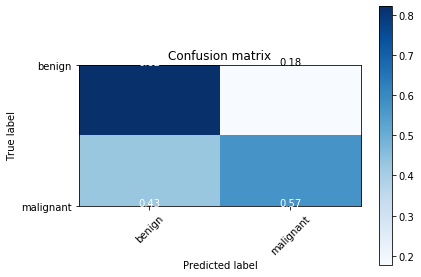

===================== Model 90 =====================


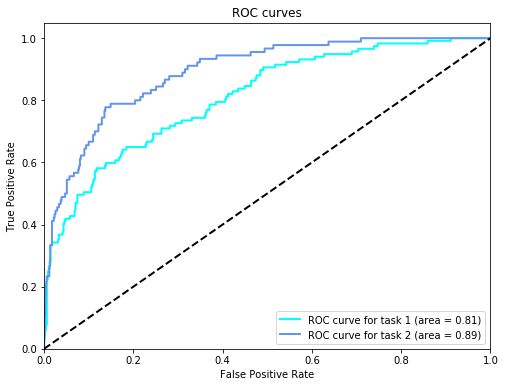

Category 1 Score: 0.810
Category 2 Score: 0.891
Category 3 Score: 0.850


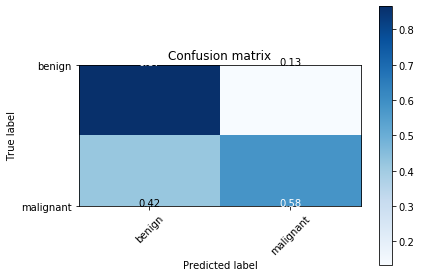

===================== Model 100 =====================


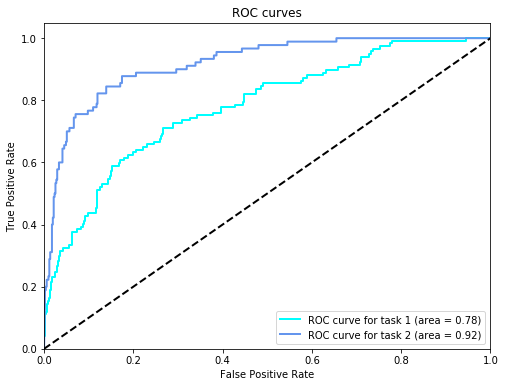

Category 1 Score: 0.780
Category 2 Score: 0.918
Category 3 Score: 0.849


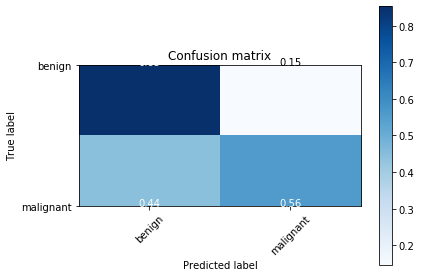

In [0]:
for i in range(10):
    print(f'===================== Model {(i+1)*10} =====================')
    plotMetrics(f'preds{i}.csv', 0.23)

## Evaluating single model

In [0]:
model = torch.load('drive/My Drive/skinpredata.pt')

Getting the predictions as csv file.

In [0]:
getPredictions(model, 'predsprebest.csv')

### Getting accuracy for the model

Getting accuracies on train, validation and test datasets.

In [0]:
target = testset.targets
class_sample_count = np.unique(target, return_counts=True)[1]
print(class_sample_count)

[117 393  90]


In [0]:
getAccuracy(model, testloader) #70


1.0869971684614816
Correct labels: 463 / 600
Correctness score: 0.7716666666666666


In [0]:
getAccuracy(model, trainloader) #95


1.5599480796817626
Correct labels: 2725 / 3387
Correctness score: 0.8045467965751403


In [0]:
getAccuracy(model, validloader) #89


2.2095907856104784
Correct labels: 667 / 846
Correctness score: 0.7884160756501182


### Plot AUC ROC and confusion metrics

Getting AUC, ROC and confusion matrices for evaluation. Setting a threshold for confusion matrices.

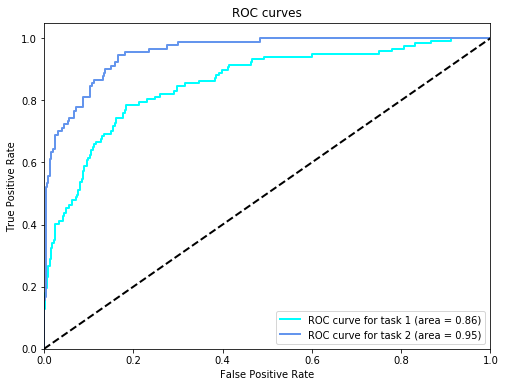

Category 1 Score: 0.855
Category 2 Score: 0.954
Category 3 Score: 0.905


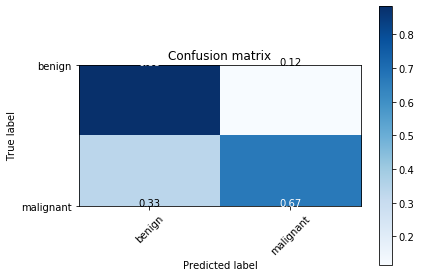

In [0]:
plotMetrics('model80.csv', 0.3)

# Evaluating best models

In [0]:
model = torch.load('drive/My Drive/model80.pt')
getPredictions(model, 'drive/My Drive/model80.csv')
model = torch.load('drive/My Drive/skinpredata50prev.pt')
getPredictions(model, 'drive/My Drive/skinpredata50prev.csv')

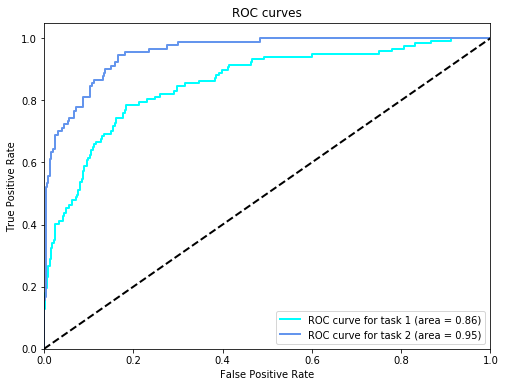

Category 1 Score: 0.855
Category 2 Score: 0.954
Category 3 Score: 0.905


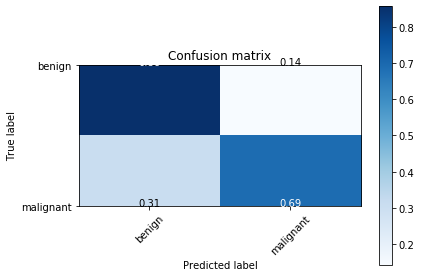

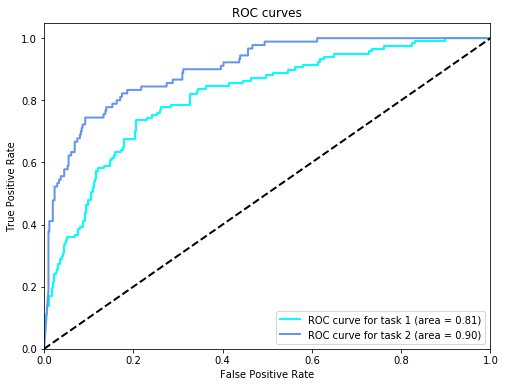

Category 1 Score: 0.814
Category 2 Score: 0.901
Category 3 Score: 0.858


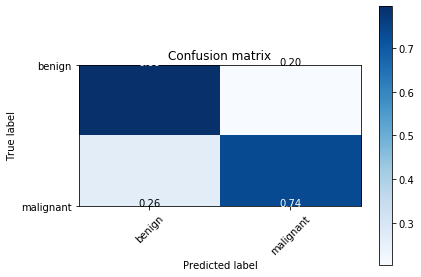

In [0]:
plotMetrics('drive/My Drive/model80.csv', 0.15)
plotMetrics('drive/My Drive/skinpredata50prev.csv', 0.38)